**Lecturer:** Sipos, Róbert<br>
**E-mail:** istvan.robert.sipos@citi.com<br>
**Web:** http://www.hit.bme.hu/~siposr/

![Robi S](img\SIPOS_Istvan_Robert.jpg)

# Monte Carlo simulations

Python for Finance, CEU, 17th May, 2018

## Overview

- [Introduction to the concept of Monte Carlo simulations](#Introduction)
- [Option pricing with MC, measure its accuracy](#OptionPricing)
- [Numerical techniques to reduce the number of steps](#Numerical)
- [Pricing exotics](#Exotics)

## <a name="Introduction">Introduction</a>

The concept of Monte Carlo methods allows us to estimate quantities we otherwise cannot observe directly. This is done by obtaining random samples from a given distribution, use it to evaluate a certain function and take their average. For instance, we can simulate many possible paths for a random process by sampling a random variable.

### Example: estimating $\pi$ by throwing darts

Throw darts randomly a unit square. Imagine a circle with a unit diameter centered in the square, such as:

![Darts](img\darts.png)

How many of the darts would end up in the circle?

The area of the circle is $\pi \over 4$, while the square has area of 1. By simulating a number of trials ($N$), we can estimate $P(dart~in~the~circle)$ as the number of the samples in the circle over $N$. From this we get
$$\hat \pi = 4 P(dart~in~the~circle) .$$

Let random variables $X \sim U(-0.5,0.5)$ and $Y \sim U(-0.5,0.5)$ to be the coordinates of the simulated throw.

**Task: please implement a Monte Carlo estimation for $\pi$. Hints:**
- `np.random.uniform()`
- A dart is inside the circle if $x^2+y^2 < 0.5^2$.

**Task 2: try to use NumPy functions only without a for loop. Hints:**
- `np.linalg.norm()`
- `np.sum()`

In [1]:
import numpy as np
from math import exp, sqrt, ceil

N = 10000

# TODO <<<
count = 0
for i in range(N):
    (x, y) = (np.random.uniform()-0.5, np.random.uniform()-0.5)
    if (x**2+y**2<0.5**2):
        count = count + 1
1.0*count/N*4
# TODO >>>

3.1376

In [2]:
# TODO <<<
coordinates = np.random.uniform(size=(N, 2))
norms = np.linalg.norm(coordinates - 0.5, axis=1)
pi = np.sum(norms < 0.5)/N*4
pi
# TODO >>>

3.1307999999999998

## <a name="OptionPricing">Pricing a derivative</a>

Consider a derivative on a single underlying $S$ with payoff at time $T$. Applying Monte Carlo for pricing:

1. Repeat $N$ times:
 - Simulate a random path for $S$;
 - Calculate its payoff.

2. Get the mean of the sampled payoffs.

3. Discount with the risk-free rate $r$ (assumed as constant).

Similarly as previously, let's price a European call option, where:
* Current price of the underlying stock: &nbsp; $S_{\ 0}$
* Volatility of the underlying stock: &nbsp; $\sigma$
* Strike price of the option: &nbsp; $K$
* Payoff = $(S(T)-K)^+$
* $DF = e^{-rT}$

In [3]:
from collections import namedtuple

r = 0.15

underlying = namedtuple("underlying", "S0 sigma")
option = namedtuple("option", "K T")
payoff = lambda S, K: max(S[-1]-K, 0)
df = lambda r, T: exp(-r*T)

stock = underlying(S0=100, sigma=0.30)
opt = option(K=110, T=1)

What is missing? We need to simulate random trajectories for the underlying's price. Remember that we modelled the stock price $S(t)$ as a generalized Wiener process. We also derived the following It&ocirc; process:

$$dS=\mu\ S\ dt+\sigma\ S\ dz\ ,$$

where $\ dz\ $ is the change of a Wiener process during the very short time $\ dt\ $, $\mu$ is the expected return - for a non-dividend-paying stock equals to the risk-free rate $r$ -, and $\sigma$ is the volatility.

For the purpose of Monte Carlo sampling we would need to generate random paths for $S$. One can construct a discrete time estimation for this process by dividing $T$ into $M$ intervals of length $\Delta t$ as:

<span style="color:#d00">$$S(t+\Delta t) - S(t) = \mu S(t) \Delta t + \sigma S(t) \epsilon \sqrt{\Delta t} , $$</span>

where $\epsilon$ is a random sample from a standard normal distribution. Iteratively using this equation $M$ times produces a path of $S$.

However,

$$ d ~ ln ~ S = \left( \mu + {\sigma^2 \over 2} \right ) dt + \sigma dz, $$
so
$$ ln ~ S(t) - ln ~ S(0) = \left( \mu + {\sigma^2 \over 2} \right ) t + \sigma \epsilon \sqrt{t}, $$
or
$$ S(t) = S(0) e^{\left( \mu + {\sigma^2 \over 2} \right ) t + \sigma \epsilon \sqrt{t}}. $$

As opposed to the previous case, which only holds when $\Delta t \to 0$, this is true for all $t$. If the trajectory is not important in the pricing, with this method, we can obtain the value at $T$ in only one step in contrast to $M$ steps.

**Task: please finish the following function to simulate $S$ until its maturity. Use the discrete time estimation above.**

**Task 2: again, try to use NumPy functions only without a for loop. Hints:**
- `np.cumprog()`

Discounted payoff = 26.38$



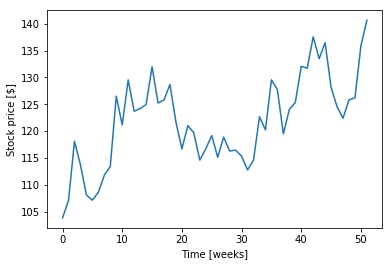

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# S0: current price ($)
# T: maturity (in years)
# M: number of time intervals
# mu: expected return of the stock
# sigma: volatility of the stock
# epsilon: list of random samples (length of M)
# Returns a simulated path of S (length of M+1)
def get_path(S0, T, M, mu, sigma, epsilon):
    # TODO <<<
    #S = [None] * (M+1)
    #S[0] = S0
    
    #dt = 1.0*T/M
    #for t in range(M):
    #    #S[t] = S0 * exp((mu+(sigma**2)/2)*(t*dt)+sigma*epsilon[t]*sqrt(t*dt))
    #    S[t+1] = S[t]+mu*S[t]*dt+sigma*S[t]*epsilon[t]*sqrt(dt)

    #return S
    # TODO >>>

    # TODO <<<
    dt = 1.0*T/M
    return S0 * np.cumprod(epsilon*sigma*sqrt(dt) + mu*dt + 1)
    # TODO >>>

# Plot a random path and calculate its discounted payoff
M = 52
epsilon = np.random.normal(size=M)
S = get_path(stock.S0, opt.T, M, r, stock.sigma, epsilon)

plt.plot(S)
plt.ylabel('Stock price [$]')
plt.xlabel('Time [weeks]')

p = payoff(S, opt.K)*df(r, opt.T)
print('Discounted payoff = %.2f$\n' % (p))

Having these pieces at hand, now we are ready to put together a Monte Carlo pricer for the option. In the example above, we simulated one random path and calculated the discounted payoff belonging to it. For pricing the option, we need to repeat this $N$ times and take their average as the price of the option.

**Task: fill in the Monte Carlo algorithm.**

In [5]:
# stock: a named tuple describing the underlying stock (S0, sigma)
# opt: a named tuple describing the option (K, T)
# r: risk-free interest rate
# N: number of Monte Carlo steps
# M: number of time intervals during the simulation
# Returns the price of the option.
def mc(stock, opt, r=r, N=1000, M=100, payoff=payoff):
    # TODO <<<
    p = 0
    for k in range(N):
        epsilon = np.random.normal(size=M)
        S = get_path(stock.S0, opt.T, M, r, stock.sigma, epsilon)
        p += payoff(S, opt.K)*df(r, opt.T)
    return p/N
    # TODO >>>

print('Option value = %.2f$' % (mc(stock, opt)))

Option value = 15.33$


### Choosing the number of trials

Note that running the pricer multiple times gives somewhat different prices each time. Naturally, the accuracy of the estimation increases with the number of trials. First, we should calculate the standard deviation $\omega$ of the simulated payoffs. Their mean $\hat{C}$, as before, is our final estimation for the derivative's price $C$. We can use this to establish e.g. a 95% confidence interval for the price:
$$ \hat{C} - {1.96\omega \over \sqrt{N}} < C < \hat{C} + {1.96\omega \over \sqrt{N}} . $$
This range is proportional with ${1 \over \sqrt{N}}$, in other words, increasing the accuracy by a factor of 10, we need 100 times more samples.

In [6]:
def calc_stats(values):
    N = len(values)
    numbers = np.arange(1, N+1)
    sqrt_numbers = np.sqrt(numbers)

    mean = np.cumsum(values) / numbers
    std = np.zeros(N)
    for n in range(N):
        std[n] = np.std(values[:n+1])
    #std = np.sqrt(np.cumsum((values - mean) ** 2) / numbers)
    lower = mean - 1.96 * std / sqrt_numbers
    upper = mean + 1.96 * std / sqrt_numbers

    return mean, std, lower, upper

In [7]:
N = 10000
p_vec = np.array([None] * N)
for k in range(N):
    p_vec[k] = mc(stock, opt, N=1)
mean, std, lower, upper = calc_stats(p_vec)

for n in [100, 1000, 10000]:
    print('For %d steps: %.2f$ < C < %.2f$ with 95%% confidence.' % (n, lower[n-1], upper[n-1]))

For 100 steps: 6.44$ < C < 12.68$ with 95% confidence.
For 1000 steps: 12.85$ < C < 15.62$ with 95% confidence.
For 10000 steps: 14.09$ < C < 14.98$ with 95% confidence.


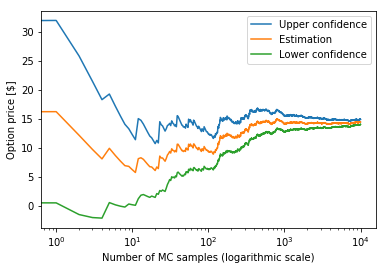

In [8]:
plt.plot(upper[1:])
plt.plot(mean[1:])
plt.plot(lower[1:])

plt.ylabel('Option price [$]')
plt.xlabel('Number of MC samples (logarithmic scale)')
plt.xscale('log')
plt.legend(['Upper confidence', 'Estimation', 'Lower confidence'])

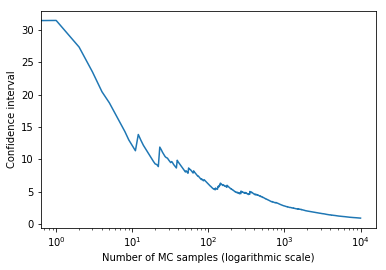

In [9]:
plt.plot(upper[1:]-lower[1:])
plt.ylabel('Confidence interval')
plt.xlabel('Number of MC samples (logarithmic scale)')
plt.xscale('log')
plt.show()

It is then depends on the application after how many steps we consider the MC converged.

## <a name="Numerical">Variance reduction techniques</a>

One can notice that the confidence interval depends on $\omega$, thus if there is a way to reduce the standard deviation (or variance) of the Monte Carlo samples then less samples would be sufficient for the same accuracy saving computational time.

#### Antithetic variable technique

The main idea is the following: for each random $\epsilon$ used to calculate the payoff repeat the calculation with $-\epsilon$ as well. The sample will be their average. Intuitively, one is above the true value, while the other is usually below. This method promises a much lower standard deviation than simply taking $2N$ samples.

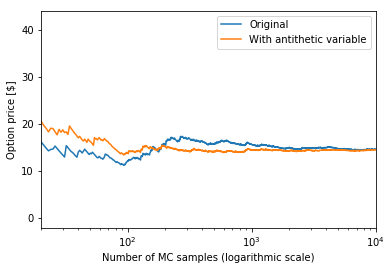

In [10]:
p_vec_old = [None] * N
p_vec_new = [None] * N

M = 100
discount_factor = df(r, opt.T)
for k in range(0, N, 2):
    epsilon = np.random.normal(size=M)
    S = get_path(stock.S0, opt.T, M, r, stock.sigma, epsilon)
    p_vec_old[k] = payoff(S, opt.K) * discount_factor
    p_vec_new[k] = payoff(S, opt.K) * discount_factor
    
    epsilon = -epsilon
    S = get_path(stock.S0, opt.T, M, r, stock.sigma, epsilon)
    p_vec_new[k+1] = payoff(S, opt.K) * discount_factor
    
    epsilon = np.random.normal(size=M)
    S = get_path(stock.S0, opt.T, M, r, stock.sigma, epsilon)
    p_vec_old[k+1] = payoff(S, opt.K) * discount_factor

mean_old, std_old, lower_old, upper_old = calc_stats(p_vec_old)
mean_new, std_new, lower_new, upper_new = calc_stats(p_vec_new)

plt.plot(mean_old[1:], label="Original")
plt.plot(mean_new[1:], label="With antithetic variable")
plt.ylabel('Option price [$]')
plt.xlabel('Number of MC samples (logarithmic scale)')
plt.xscale('log')
plt.xlim([20, 10000])
plt.legend()
plt.show()

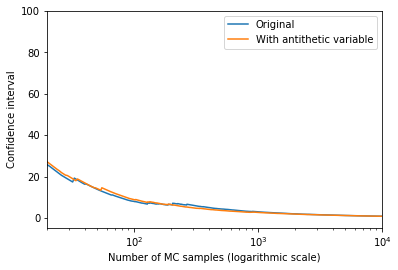

In [11]:
plt.plot(upper_old - lower_old, label='Original')
plt.plot(upper_new - lower_new, label='With antithetic variable')
plt.ylabel('Confidence interval')
plt.xlabel('Number of MC samples (logarithmic scale)')
plt.xscale('log')
plt.xlim([20, 10000])
plt.legend()
plt.show()

#### Importance sampling

In this technique, the original distribution is sampled based on the variance of the payoff. If let's say we have a knock-out barrier option, where the payoff is constant 0 if the price is below a certain threshold, we sample only the cases when its above and weigh it with its probability.

#### Stratified sampling

This method also considers how $\epsilon$ is chosen. Selecting representative values instead of random samples usually increases accuracy, or equivalently increases speed. First, divide the distribution into $L$ equally probable region. Such representative values are the means of these intervals. In the case of $\epsilon \sim N(0,1)$:

$$ \epsilon_i = \Phi^{-1} \left ( {i-0.5 \over L} \right ) , $$

where $\Phi^{-1}$ denotes the inverse cumulative normal distribution.

## <a name="Exotics">Pricing exotics</a>

### Asian options

In the case of Asian options, the payoff depends on the average of the underlying stock prices until maturity $T$. I.e.
$$Payoff = \left( {1 \over M} \sum_{i=0}^{M} {S(t_i)}-K \right)^+ .$$

Not surprisingly, the price of an Asian option is generaly cheaper than its European counterpart.

**Task: please implement an Asian type payoff function and compare the European and Asian option prices.**

In [12]:
print('European option value = %.2f$' % mc(stock, opt))

# TODO <<<
asian_payoff = lambda S, K: max(np.mean(S)-K, 0)
# TODO >>>

print('Asian option value = %.2f$' % mc(stock, opt, payoff=asian_payoff))

European option value = 14.36$
Asian option value = 5.74$


### Multiple underlyings

Basket options are exotics options with a payoff function depending on a weighted sum of multiple underlying prices.

Similarly to the simple case, when there is only one underlying instrument, their process is described by:

$$S_i(t+\Delta t) - S_i(t) = \mu_i S_i(t) \Delta t + \sigma_i S_i(t) \epsilon_i \sqrt{\Delta t}  , $$

however, they are correlated through $\epsilon_i$ with the coefficients $\rho_{ij} = corr(\epsilon_i, \epsilon_j)$. Simulating such process requires sampling from a multivariate normal distribution.

For example, when dealing with two underlyings and $u_i$ denotes a sample from a univariate distribution, then (for more details, see also Cholesky decomposition):
$$ \epsilon_1 = u_1 $$
$$ \epsilon_2 = \rho u_1 + u_2 \sqrt {1-\rho^2} $$

**Task: implement a Monte Carlo pricer for a basket option with the following payoff function.**

$$Payoff = \left( S_1(T)+S_2(T)-K \right)^+ .$$

In [13]:
def mc2(stock1, stock2, opt, r=r, N=1000, M=100, rho=0.0):
    # TODO <<<
    p = 0
    for k in range(N):
        epsilon1 = np.random.normal(size=M)
        epsilon2 = np.random.normal(size=M)
        epsilon2 = rho*epsilon1 + sqrt(1-rho**2)*epsilon2

        S1 = get_path(stock1.S0, opt.T, M, r, stock1.sigma, epsilon1)
        S2 = get_path(stock2.S0, opt.T, M, r, stock2.sigma, epsilon2)
        basket = S1+S2

        p += payoff(basket, opt.K)*df(r, opt.T)
    return p/N
    # TODO >>>

basket_opt = option(K=200, T=1)
stock1 = underlying(S0=100, sigma=0.30)
stock2 = underlying(S0=80, sigma=0.10)
print('Basket option value = %.2f$' % (mc2(stock1, stock2, basket_opt, rho=0.5)))

Basket option value = 17.37$


## References

[1] [John C. Hull: Options, Futures, and Other Derivatives](https://www.amazon.co.uk/Options-Futures-Other-Derivatives-Global/dp/1292212896/)